In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from time import time

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from operator import add

sc = SparkContext("local[40]", 'parallel_stocks')
sc.setLogLevel('warn')

In [3]:
    sql_c = SQLContext(sc)
    df = sql_c.read.csv("../data/processed/bitstampUSD.csv", header=True, inferSchema=True)
    print(df.limit(5).toPandas())


    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980  4.39  4.39  4.39   4.39      0.000000                0.0   
2  1325318040  4.39  4.39  4.39   4.39      0.000000                0.0   
3  1325318100  4.39  4.39  4.39   4.39      0.000000                0.0   
4  1325318160  4.39  4.39  4.39   4.39      0.000000                0.0   

   Weighted_Price  
0            4.39  
1            4.39  
2            4.39  
3            4.39  
4            4.39  


In [4]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

In [5]:
    stages = []
    unscaled_features = df.columns
    unscaled_features.remove("Weighted_Price")
    # print(unscaled_features)
    unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
    scaler = MinMaxScaler(inputCol="unscaled_features", outputCol="scaled_features")
    stages += [unscaled_assembler, scaler]

    pipeline = Pipeline(stages=stages)
    pipeline_model = pipeline.fit(df)
    df_transform = pipeline_model.transform(df)

    df_transform_fin = df_transform.select('scaled_features', 'Weighted_Price', 'Timestamp')
    df_transform_fin = df_transform_fin.withColumnRenamed("scaled_features", "features")
    print(df_transform_fin.limit(5).toPandas())

    # split data into test/train datasets
    train_data = df_transform_fin.filter(df_transform_fin["Timestamp"] <= 1529899200).select('features', "Weighted_Price")  # 25-Jun-2018
    test_data = df_transform_fin.filter(df_transform_fin["Timestamp"] > 1529899200).select('features', "Weighted_Price")
    input_dim = len(train_data.select("features").first()[0])
    print(train_data.select("features").first())
    print("Input dim: %d" % input_dim)
    print("Train size: %d" % train_data.count())
    print("Test size: %d" % test_data.count())


                                            features  Weighted_Price  \
0  [0.0, 3.000718137967933e-05, 3.000681510715992...            4.39   
1  [2.184012677756792e-07, 3.000718137967933e-05,...            4.39   
2  [4.368025355513584e-07, 3.000718137967933e-05,...            4.39   
3  [6.552038033270375e-07, 3.000718137967933e-05,...            4.39   
4  [8.736050711027168e-07, 3.000718137967933e-05,...            4.39   

    Timestamp  
0  1325317920  
1  1325317980  
2  1325318040  
3  1325318100  
4  1325318160  
Row(features=DenseVector([0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0]))
Input dim: 7
Train size: 3403217
Test size: 1169040


In [6]:
df.take(1)


[Row(Timestamp=1325317920, Open=4.39, High=4.39, Low=4.39, Close=4.39, Volume_(BTC)=0.45558087, Volume_(Currency)=2.0000000193000003, Weighted_Price=4.39)]

In [7]:
df.take(1)

[Row(Timestamp=1325317920, Open=4.39, High=4.39, Low=4.39, Close=4.39, Volume_(BTC)=0.45558087, Volume_(Currency)=2.0000000193000003, Weighted_Price=4.39)]

In [8]:
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



# Linear Regression to check the best value for L2 regularization

In [9]:
reg=[0,0.1,0.3,0.5,1,10,100,1000,2000,3000,5000]
score={}
score_train={}
time_taken={}
for val in reg:
        print("_"*50)
        print("L2 regularization value={}".format(val))
        print("_"*50)
    
        now = time()
        lr = LinearRegression(featuresCol = 'features', labelCol='Weighted_Price', maxIter=10, regParam=val,elasticNetParam=0)
        lr_model = lr.fit(train_data)
        end = time()-now        
        print("Coefficients: " + str(lr_model.coefficients))
        print("Intercept: " + str(lr_model.intercept))

        lr_predictions = lr_model.transform(test_data)
        lr_predictions_train = lr_model.transform(train_data)
        lr_predictions.select("features",'Weighted_Price','prediction').show(5)
        lr_predictions_train.select("features",'Weighted_Price','prediction').show(5)

        lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mse")
        mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")

        print("Mean Squared Error on test data = %g" % lr_evaluator.evaluate(lr_predictions))
        print("Mean Squared Error on train data = %g" % lr_evaluator.evaluate(lr_predictions_train))
        print("Mean Absolute Error on test data = %g" % mae.evaluate(lr_predictions))
        print("Mean Absolute Error on train data = %g" % mae.evaluate(lr_predictions_train))

        score[val] = lr_evaluator.evaluate(lr_predictions)
        score_train[val] = lr_evaluator.evaluate(lr_predictions_train)
        time_taken[val] = end
        sql_c.clearCache()

__________________________________________________
L2 regularization value=0
__________________________________________________
Coefficients: [-0.17807615046516623,1127.6987332702668,7589.098999600886,8324.648568105207,2616.1711050033564,-0.44125964966326575,-8.838134592364787]
Intercept: 2.5502188655182745
+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.74468040032078...|  6149.4517013| 6153.333602443195|
|[0.74468061872205...|  6154.8933686| 6155.130098361339|
|[0.74468083712332...|  6173.1871172| 6174.421487410196|
|[0.74468105552459...|  6167.4842171|6178.4481744898385|
|[0.74468127392585...|  6173.6108346| 6177.184949662481|
+--------------------+--------------+------------------+
only showing top 5 rows

+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+----

Mean Squared Error on test data = 36.3752
Mean Squared Error on train data = 17.2606
Mean Absolute Error on test data = 4.65453
Mean Absolute Error on train data = 2.47956
__________________________________________________
L2 regularization value=100
__________________________________________________
Coefficients: [115.47850907327853,4838.925487145871,4832.973169620446,4842.880873294825,4839.843567112492,-983.176946246318,2250.4991449333847]
Intercept: -18.691720158096853
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|6124.934861986818|
|[0.74468061872205...|  6154.8933686|6154.532801847902|
|[0.74468083712332...|  6173.1871172| 6171.41028900521|
|[0.74468105552459...|  6167.4842171|6164.327839985039|
|[0.74468127392585...|  6173.6108346|6192.560896952936|
+--------------------+--------------+-----------------+
only showing top 5 

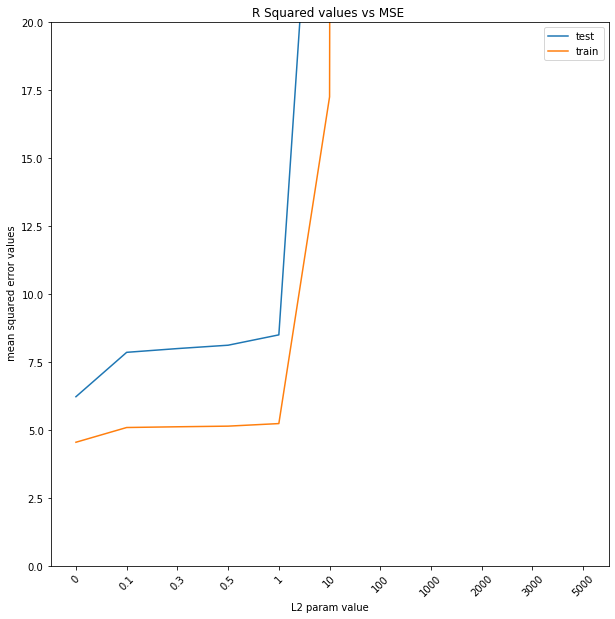

In [10]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), list(score.keys()),rotation=45);
plt.xlabel("L2 param value");
plt.ylabel(" mean squared error values");
plt.title("R Squared values vs MSE ");
plt.ylim(0,20)
plt.legend();

Coefficients: [-0.17807615079277195,1127.6987362263733,7589.098996712155,8324.648567884547,2616.1711051594343,-0.44125965281847745,-8.838134560195956]
Intercept: 2.5502188655872557


/home/nudatalab/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


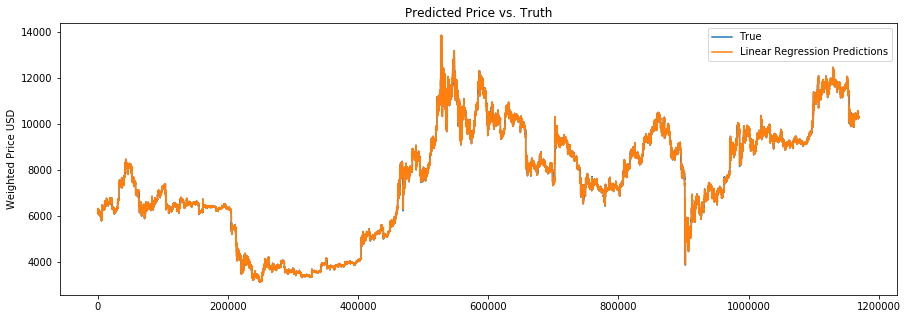

In [23]:
lr = LinearRegression(featuresCol = 'features', labelCol='Weighted_Price', maxIter=10, regParam=0,elasticNetParam=0)
lr_model = lr.fit(train_data)
        
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))
end = time()-now
lr_predictions = lr_model.transform(test_data)

plt.figure(figsize=(15,5))
plt.plot(test_data.select('Weighted_Price').toPandas());
plt.plot(lr_predictions.select('prediction').toPandas());
plt.title("Predicted Price vs. Truth");
plt.ylabel("Weighted Price USD");
plt.legend(["True", "Linear Regression Predictions"]);

### Linear regression is able to fit the model so well that the blue and orange line merge

### Test value is the lowest at lambda = 0 

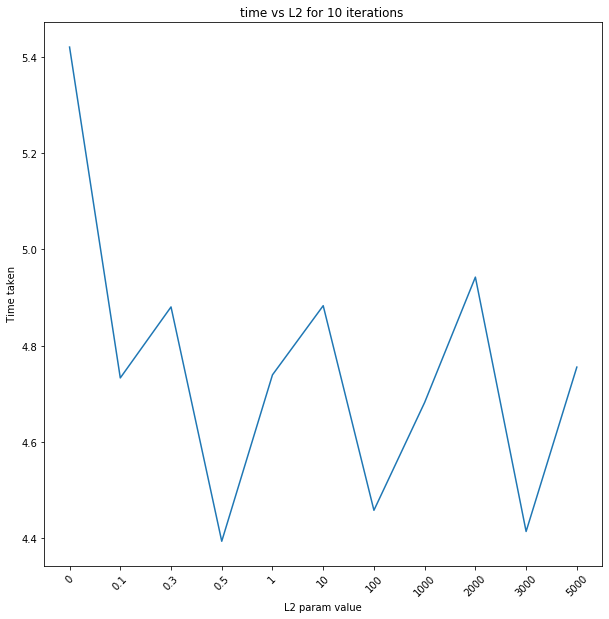

In [24]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(time_taken.values()))) , list(time_taken.values()));
plt.xticks(np.arange(len(list(time_taken.values()))), list(time_taken.keys()),rotation=45);
plt.xlabel("L2 param value");
plt.ylabel(" Time taken");
plt.title("time vs L2 for 10 iterations ");


### Time taken per 10 iterations for varying values of lambda is around 4.5 seconds

# Linear Regression to check the best value for L1 regularization

In [25]:
reg=[0,0.1,0.3,0.5,1,10,100,1000,2000,3000,5000]
score={}
score_train={}
time_taken={}
for val in reg:
        print("_"*50)
        print("L1 regularization value={}".format(val))
        print("_"*50)
    
        now = time()
        lr = LinearRegression(featuresCol = 'features', labelCol='Weighted_Price', maxIter=10, regParam=val,elasticNetParam=1)
        lr_model = lr.fit(train_data)
        
        print("Coefficients: " + str(lr_model.coefficients))
        print("Intercept: " + str(lr_model.intercept))
        end = time()-now
        lr_predictions = lr_model.transform(test_data)
        lr_predictions_train = lr_model.transform(train_data)
        lr_predictions.select("features",'Weighted_Price','prediction').show(5)
        lr_predictions_train.select("features",'Weighted_Price','prediction').show(5)

        lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mse")

        mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")

        print("Mean Squared Error on test data = %g" % lr_evaluator.evaluate(lr_predictions))
        print("Mean Squared Error on train data = %g" % lr_evaluator.evaluate(lr_predictions_train))
        print("Mean Absolute Error on test data = %g" % mae.evaluate(lr_predictions))
        print("Mean Absolute Error on train data = %g" % mae.evaluate(lr_predictions_train))

        score[val] = lr_evaluator.evaluate(lr_predictions)
        score_train[val] = lr_evaluator.evaluate(lr_predictions_train)
        time_taken[val] = end
        sql_c.clearCache()

__________________________________________________
L1 regularization value=0
__________________________________________________
Coefficients: [-0.17807615079277195,1127.6987362263733,7589.098996712155,8324.648567884547,2616.1711051594343,-0.44125965281847745,-8.838134560195956]
Intercept: 2.5502188655872557
+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.74468040032078...|  6149.4517013|6153.3336024423315|
|[0.74468061872205...|  6154.8933686| 6155.130098361846|
|[0.74468083712332...|  6173.1871172| 6174.421487407323|
|[0.74468105552459...|  6167.4842171|6178.4481744882705|
|[0.74468127392585...|  6173.6108346|6177.1849496640025|
+--------------------+--------------+------------------+
only showing top 5 rows

+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+----

Mean Squared Error on test data = 489.677
Mean Squared Error on train data = 105.151
Mean Absolute Error on test data = 20.4167
Mean Absolute Error on train data = 6.36954
__________________________________________________
L1 regularization value=100
__________________________________________________
Coefficients: [0.0,4753.074523855912,4747.395554230413,4756.52059710713,4753.847422652397,0.0,0.0]
Intercept: 53.03386788537444
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|6000.679875085963|
|[0.74468061872205...|  6154.8933686|6004.512885876728|
|[0.74468083712332...|  6173.1871172|6019.000721354986|
|[0.74468105552459...|  6167.4842171|6024.537009496155|
|[0.74468127392585...|  6173.6108346|6026.502511736746|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+----

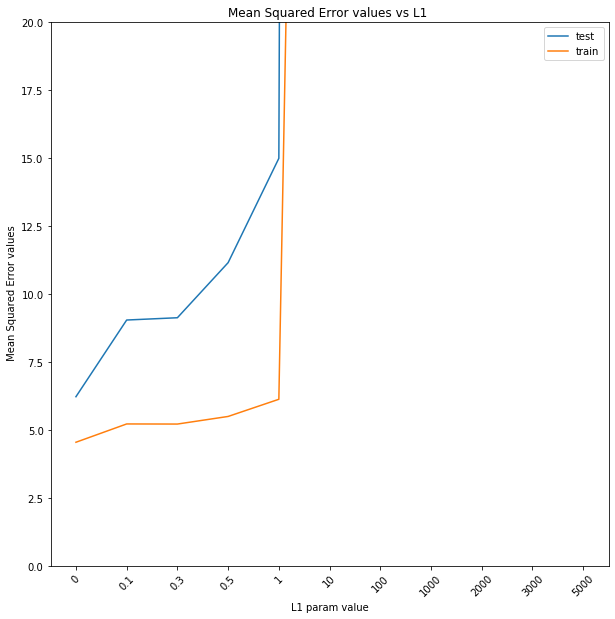

In [26]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), list(score.keys()),rotation=45);
plt.xlabel("L1 param value");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs L1 ");
plt.ylim(0,20)
plt.legend();

### Test value is the lowest at lambda = 0 

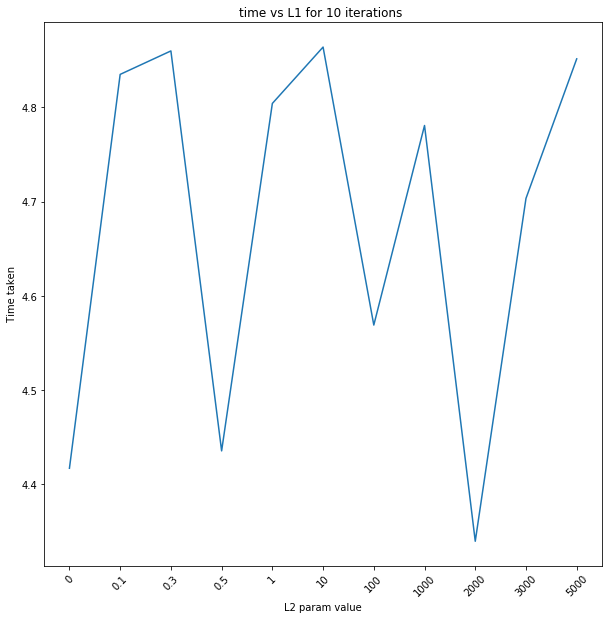

In [27]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(time_taken.values()))) , list(time_taken.values()));



plt.xticks(np.arange(len(list(time_taken.values()))), list(time_taken.keys()),rotation=45);
plt.xlabel("L2 param value");
plt.ylabel(" Time taken");
plt.title("time vs L1 for 10 iterations ");


### Time taken per 10 iterations for varying values of lambda is around 4.5 seconds

#### We can combine both the losses and check if we can reduce the test_data loss

In [28]:
elas=[0.2,0.3,0.5,0.7]
reg=[0,0.1,0.2]
score={}
score_train={}
time_taken={}
param={}
count=0
for temp in elas:
    for val in reg:
            print("_"*50)
            print("regularization value={} , mixing value={}".format(val,temp))
            print("_"*50)

            now = time()
            lr = LinearRegression(featuresCol = 'features', labelCol='Weighted_Price', maxIter=10, regParam=val,elasticNetParam=temp)
            lr_model = lr.fit(train_data)

            print("Coefficients: " + str(lr_model.coefficients))
            print("Intercept: " + str(lr_model.intercept))
            end = time()-now
            lr_predictions = lr_model.transform(test_data)
            lr_predictions_train = lr_model.transform(train_data)
            lr_predictions.select("features",'Weighted_Price','prediction').show(5)
            lr_predictions_train.select("features",'Weighted_Price','prediction').show(5)

            lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                             labelCol='Weighted_Price',metricName="mse")

            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")

            print("Mean Squared Error on test data = %g" % lr_evaluator.evaluate(lr_predictions))
            print("Mean Squared Error on train data = %g" % lr_evaluator.evaluate(lr_predictions_train))
            print("Mean Absolute Error on test data = %g" % mae.evaluate(lr_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(lr_predictions_train))

            score[count] = lr_evaluator.evaluate(lr_predictions)
            score_train[count] = lr_evaluator.evaluate(lr_predictions_train)
            time_taken[count] = end
            param[count]={"elas":temp,"reg":val}
            count+=1
            sql_c.clearCache()

__________________________________________________
regularization value=0 , mixing value=0.2
__________________________________________________
Coefficients: [-0.17807615037833038,1127.6987335609592,7589.09899923822,8324.648567267304,2616.171105913257,-0.44125964928929085,-8.838134597920005]
Intercept: 2.550218865493915
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|6153.333602443354|
|[0.74468061872205...|  6154.8933686|6155.130098361782|
|[0.74468083712332...|  6173.1871172|6174.421487410053|
|[0.74468105552459...|  6167.4842171|6178.448174489825|
|[0.74468127392585...|  6173.6108346|6177.184949662773|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+-------------

Mean Squared Error on test data = 9.41174
Mean Squared Error on train data = 5.29963
Mean Absolute Error on test data = 2.10889
Mean Absolute Error on train data = 0.834004
__________________________________________________
regularization value=0 , mixing value=0.5
__________________________________________________
Coefficients: [-0.1780761505656176,1127.6987342458049,7589.098998580256,8324.64856793734,2616.1711052172695,-0.4412596507020619,-8.838134581923649]
Intercept: 2.5502188655314537
+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.74468040032078...|  6149.4517013| 6153.333602442945|
|[0.74468061872205...|  6154.8933686| 6155.130098361578|
|[0.74468083712332...|  6173.1871172| 6174.421487409248|
|[0.74468105552459...|  6167.4842171| 6178.448174489315|
|[0.74468127392585...|  6173.6108346|6177.1849496630175|
+--------------------+--------------+------------

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.74468040032078...|  6149.4517013| 6152.746005973863|
|[0.74468061872205...|  6154.8933686|  6156.70940793138|
|[0.74468083712332...|  6173.1871172| 6171.690118259426|
|[0.74468105552459...|  6167.4842171| 6177.414805617194|
|[0.74468127392585...|  6173.6108346|6179.4473053374995|
+--------------------+--------------+------------------+
only showing top 5 rows

+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.0,3.0007181379...|          4.39|4.445333674471442|
|[2.18401267775679...|          4.39|4.445333674471442|
|[4.36802535551358...|          4.39|4.445333674471442|
|[6.55203803327037...|          4.39|4.445333674471442|
|[8.73605071102716...|          4.39|4.445333674471442|
+-------------

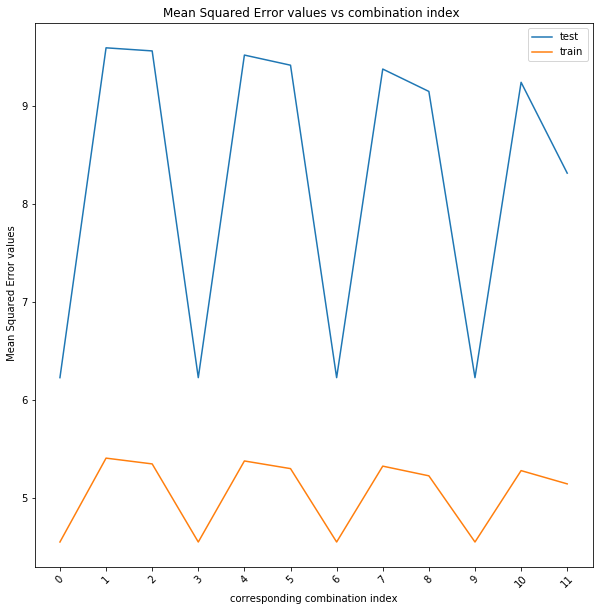

In [29]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), list(score.keys()),rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")

In [30]:
check=[0,3,6,9]
for i in check:
    print(param[i])

{'elas': 0.2, 'reg': 0}
{'elas': 0.3, 'reg': 0}
{'elas': 0.5, 'reg': 0}
{'elas': 0.7, 'reg': 0}


## We can see that for the given dataset the linear regression model performs better with a regularization parameter = 0.

# Random forest regression where we focus on 2 parameters : number of trees, depth.

## Currenty we change one parameter at a time, first we change the number of trees

In [11]:
trees=[10,15,20,25,30,35]
score={}
score_train={}
time_taken={}
count=0
param={}
for i in trees:

            print("_"*50)
            print("Number of trees = {}".format(i))
            print("_"*50)
            
            
            now = time()
            dt = RandomForestRegressor(featuresCol ='features', labelCol = 'Weighted_Price',numTrees=i)
            dt_model = dt.fit(train_data)
            end = time()-now
            dt_predictions = dt_model.transform(test_data)
            dt_predictions_train = dt_model.transform(train_data)
            dt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = dt_evaluator.evaluate(dt_predictions)
            mse_train = dt_evaluator.evaluate(dt_predictions_train)
            dt_predictions.select("features",'Weighted_Price','prediction').show(5)
            dt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(dt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(dt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]=[i]
            count+=1
            print("\n"*2)
            sql_c.clearCache()
            
            



__________________________________________________
Number of trees = 10
__________________________________________________
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|6977.498836811424|
|[0.74468061872205...|  6154.8933686|6977.498836811424|
|[0.74468083712332...|  6173.1871172|6977.498836811424|
|[0.74468105552459...|  6167.4842171|6977.498836811424|
|[0.74468127392585...|  6173.6108346|6977.498836811424|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.0,3.0007181379...|          4.39|10.270923331975782|
|[2.18401267775679...|          4.39|10.270923331975782|
|[4.36802535551358...|          4.39|10.270923331975782|
|[6.55

#### Program throws an out of memory exception whn the depth and the number of trees become high say 15,10 or vice versa

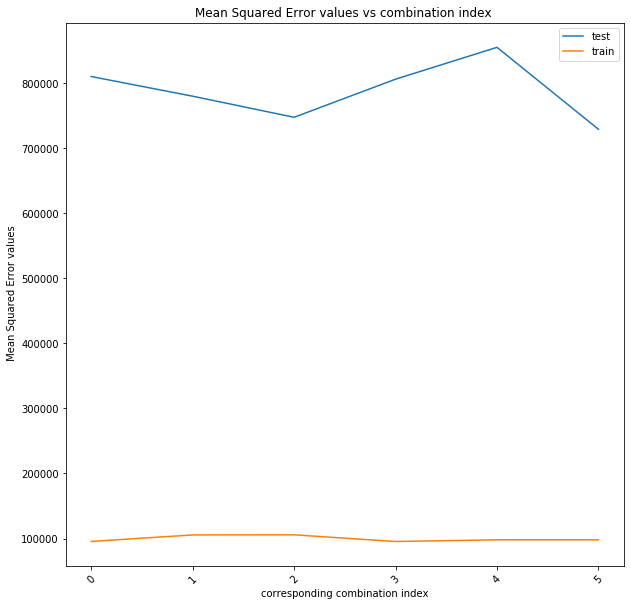

In [12]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), list(score.keys()),rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();

### the best result is produced when the number of trees=20

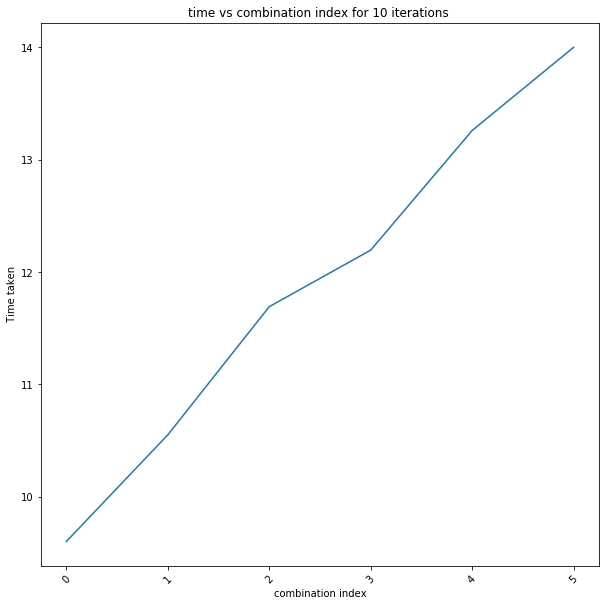

In [13]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(time_taken.values()))) , list(time_taken.values()));



plt.xticks(np.arange(len(list(time_taken.values()))), list(time_taken.keys()),rotation=45);
plt.xlabel("combination index");
plt.ylabel(" Time taken");
plt.title("time vs combination index for 10 iterations ");


### Time taken increases with the number of trees

## Currenty we change one parameter at a time, we are changing the depth to see how the test loss decreases

In [9]:
depth=[3,5,7]
score={}
score_train={}
time_taken={}
count=0
param={}
for i in depth:

            print("_"*50)
            print("Depth = {}".format(i))
            print("_"*50)
            
            
            now = time()
            dt = RandomForestRegressor(featuresCol ='features', labelCol = 'Weighted_Price',maxDepth=i)
            dt_model = dt.fit(train_data)
            end = time()-now
            dt_predictions = dt_model.transform(test_data)
            dt_predictions_train = dt_model.transform(train_data)
            dt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = dt_evaluator.evaluate(dt_predictions)
            mse_train = dt_evaluator.evaluate(dt_predictions_train)
            dt_predictions.select("features",'Weighted_Price','prediction').show(5)
            dt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(dt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(dt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]={"Depth":i}
            count+=1
            print("\n"*2)
            sql_c.clearCache()
            
            



__________________________________________________
Depth = 3
__________________________________________________
+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.74468040032078...|  6149.4517013|4734.0760622892685|
|[0.74468061872205...|  6154.8933686|4734.0760622892685|
|[0.74468083712332...|  6173.1871172| 6029.708984525812|
|[0.74468105552459...|  6167.4842171| 7029.118040930254|
|[0.74468127392585...|  6173.6108346| 7029.118040930254|
+--------------------+--------------+------------------+
only showing top 5 rows

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.0,3.0007181379...|          4.39|202.92478182525693|
|[2.18401267775679...|          4.39|202.92478182525693|
|[4.36802535551358...|          4.39|202.92478182525693|
|[6.5520

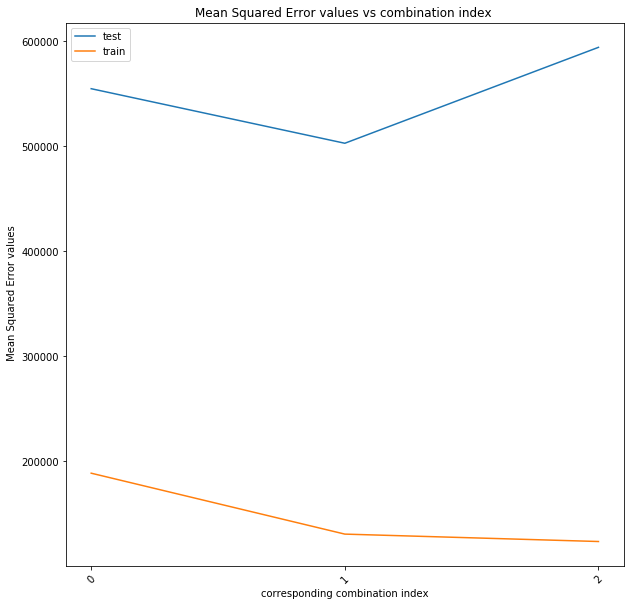

In [10]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), list(score.keys()),rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();

### num_trees=20, depth=5 is the best values

In [11]:
            i=5
            j=20
            print("_"*50)
            print("Depth = {},number of trees= {}".format(i,j))
            print("_"*50)
            
            
            now = time()
            dt = RandomForestRegressor(featuresCol ='features', labelCol = 'Weighted_Price',maxDepth=i,numTrees=j)
            dt_model = dt.fit(train_data)
            end = time()-now
            dt_predictions = dt_model.transform(test_data)
            dt_predictions_train = dt_model.transform(train_data)
            dt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = dt_evaluator.evaluate(dt_predictions)
            mse_train = dt_evaluator.evaluate(dt_predictions_train)
            dt_predictions.select("features",'Weighted_Price','prediction').show(5)
            dt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(dt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(dt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]={"Depth":i,"trees":j}
            count+=1
            print("\n"*2)
            sql_c.clearCache()

__________________________________________________
Depth = 5,number of trees= 20
__________________________________________________
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013| 5598.92383090201|
|[0.74468061872205...|  6154.8933686|5562.439771378548|
|[0.74468083712332...|  6173.1871172| 6269.56419649027|
|[0.74468105552459...|  6167.4842171|6701.101630702504|
|[0.74468127392585...|  6173.6108346|6701.101630702504|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.0,3.0007181379...|          4.39|18.082895588597815|
|[2.18401267775679...|          4.39|18.082895588597815|
|[4.36802535551358...|          4.39|18.08289558859781

/home/nudatalab/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


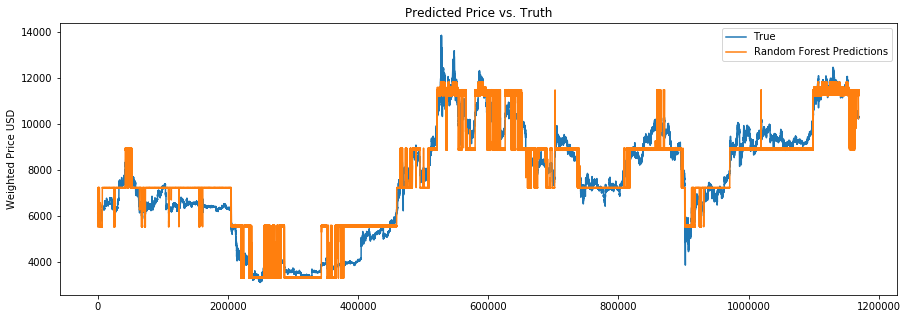

In [12]:
plt.figure(figsize=(15,5))
plt.plot(test_data.select('Weighted_Price').toPandas());
plt.plot(dt_predictions.select('prediction').toPandas());
plt.title("Predicted Price vs. Truth");
plt.ylabel("Weighted Price USD");
plt.legend(["True", "Random Forest Predictions"]);

# Gradient Boosted Regression where we focus on 3 parameters : number of trees, number of bins, depth.

# changing step size alone

In [10]:
step=[0.1,0.2,0.5,1]
bins=[5,10,15,20] # need to be greater than equal to 2
depth=[10,15,20,30] # needs to be less than equal to 30
score={}
score_train={}
time_taken={}
count=0
param={}
for i in step:
    
            print("_"*50)
            print("step_size = {}".format(i))
            print("_"*50)
            
            
            now = time()
            gt = GBTRegressor(featuresCol ='features', labelCol = 'Weighted_Price',stepSize=i,maxIter=20)
            gt_model = gt.fit(train_data)
            end = time()-now
            gt_predictions = gt_model.transform(test_data)
            gt_predictions_train = gt_model.transform(train_data)
            gt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = gt_evaluator.evaluate(gt_predictions)
            mse_train = gt_evaluator.evaluate(gt_predictions_train)
            gt_predictions.select("features",'Weighted_Price','prediction').show(5)
            gt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(gt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(gt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]={"step_size":i}
            count+=1
            print("\n"*2)
            
            



__________________________________________________
step_size = 0.1
__________________________________________________
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|6281.057464447644|
|[0.74468061872205...|  6154.8933686|6298.481604951217|
|[0.74468083712332...|  6173.1871172|6298.481604951217|
|[0.74468105552459...|  6167.4842171|6278.941382294894|
|[0.74468127392585...|  6173.6108346|6308.902258865963|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+----------------+
|            features|Weighted_Price|      prediction|
+--------------------+--------------+----------------+
|[0.0,3.0007181379...|          4.39|9.55239361288844|
|[2.18401267775679...|          4.39|9.55239361288844|
|[4.36802535551358...|          4.39|9.55239361288844|
|[6.55203803327037...| 

IllegalArgumentException: GBTRegressor_6872b547f301 parameter stepSize given invalid value 10.0.

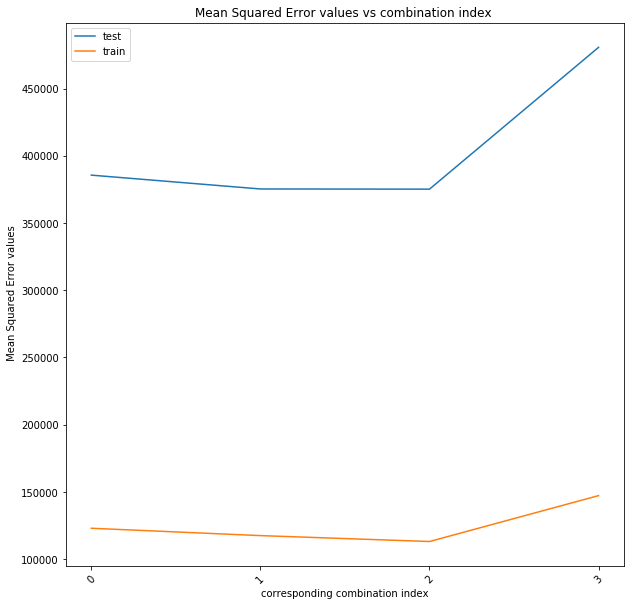

In [11]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), list(),rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();

### Keeping the step_size fixed at 0.5 while modifying depth

In [9]:
step=[0.1,0.2,0.5,1]
bins=[5,10,15,20] # need to be greater than equal to 2
depth=[3,5,7,8] # needs to be less than equal to 30
score={}
score_train={}
time_taken={}
count=0
param={}
for i in depth:
    
            print("_"*50)
            print("max_depth = {}".format(i))
            print("_"*50)
            
            
            now = time()
            gt = GBTRegressor(featuresCol ='features', labelCol = 'Weighted_Price',stepSize=0.5,maxIter=20,maxDepth=i)
            gt_model = gt.fit(train_data)
            end = time()-now
            gt_predictions = gt_model.transform(test_data)
            gt_predictions_train = gt_model.transform(train_data)
            gt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = gt_evaluator.evaluate(gt_predictions)
            mse_train = gt_evaluator.evaluate(gt_predictions_train)
            gt_predictions.select("features",'Weighted_Price','prediction').show(5)
            gt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(gt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(gt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]={"max_depth":i}
            count+=1
            print("\n"*2)
            
            



__________________________________________________
max_depth = 3
__________________________________________________
+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.74468040032078...|  6149.4517013| 7231.364511980362|
|[0.74468061872205...|  6154.8933686|7145.0218053474855|
|[0.74468083712332...|  6173.1871172|7145.0218053474855|
|[0.74468105552459...|  6167.4842171| 7126.318427576102|
|[0.74468127392585...|  6173.6108346|  7164.52773039714|
+--------------------+--------------+------------------+
only showing top 5 rows

+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.0,3.0007181379...|          4.39|6.110954341027792|
|[2.18401267775679...|          4.39|6.110954341027792|
|[4.36802535551358...|          4.39|6.110954341027792|
|[6.552038

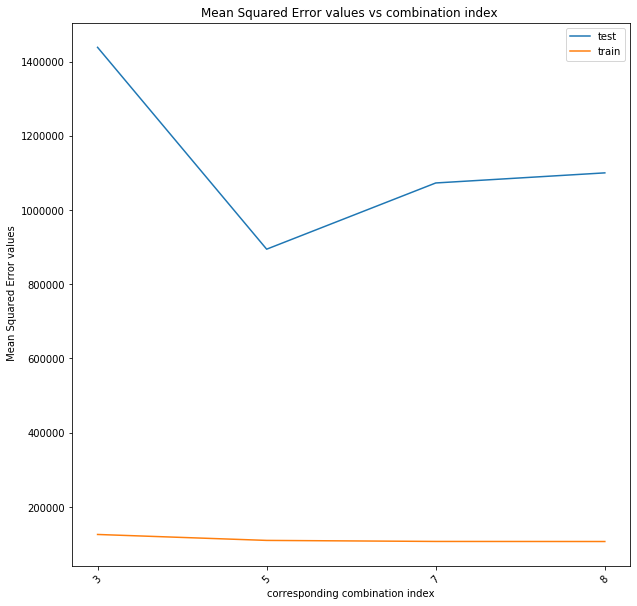

In [11]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), [3,5,7,8],rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();

### Keeping the step_size fixed at 0.2 while modifying depth

In [13]:
step=[0.1,0.2,0.5,1]
bins=[5,10,15,20] # need to be greater than equal to 2
depth=[3,5,7,8] # needs to be less than equal to 30
score={}
score_train={}
time_taken={}
count=0
param={}
for i in depth:
    
            print("_"*50)
            print("max_depth = {}".format(i))
            print("_"*50)
            
            
            now = time()
            gt = GBTRegressor(featuresCol ='features', labelCol = 'Weighted_Price',stepSize=0.2,maxIter=20,maxDepth=i)
            gt_model = gt.fit(train_data)
            end = time()-now
            gt_predictions = gt_model.transform(test_data)
            gt_predictions_train = gt_model.transform(train_data)
            gt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = gt_evaluator.evaluate(gt_predictions)
            mse_train = gt_evaluator.evaluate(gt_predictions_train)
            gt_predictions.select("features",'Weighted_Price','prediction').show(5)
            gt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(gt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(gt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]={"max_depth":i}
            count+=1
            print("\n"*2)
            
            



__________________________________________________
max_depth = 3
__________________________________________________
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|7177.341261085006|
|[0.74468061872205...|  6154.8933686|7180.114037261772|
|[0.74468083712332...|  6173.1871172|7180.114037261772|
|[0.74468105552459...|  6167.4842171|7182.333035577601|
|[0.74468127392585...|  6173.6108346|7180.114037261772|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.0,3.0007181379...|          4.39|12.708167820284611|
|[2.18401267775679...|          4.39|12.708167820284611|
|[4.36802535551358...|          4.39|12.708167820284611|
|[6.552038033

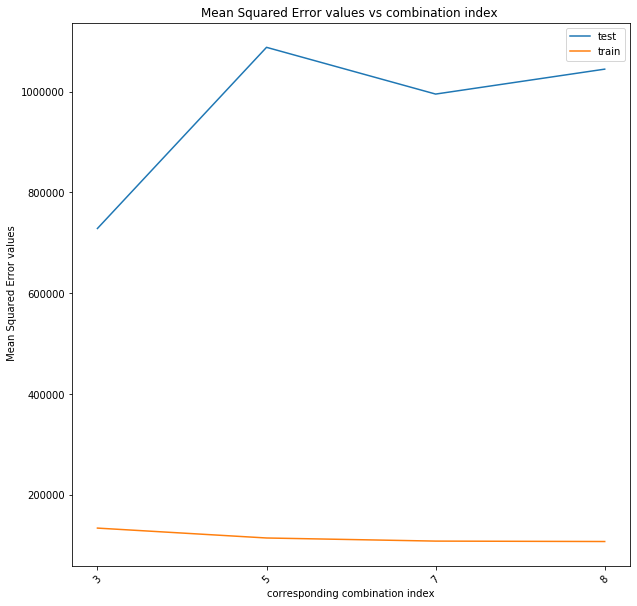

In [14]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), [3,5,7,8],rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();

### Keeping the step_size fixed at 0.6 while modifying depth

In [15]:
step=[0.1,0.2,0.5,1]
bins=[5,10,15,20] # need to be greater than equal to 2
depth=[3,5,7,8] # needs to be less than equal to 30
score={}
score_train={}
time_taken={}
count=0
param={}
for i in depth:
    
            print("_"*50)
            print("max_depth = {}".format(i))
            print("_"*50)
            
            
            now = time()
            gt = GBTRegressor(featuresCol ='features', labelCol = 'Weighted_Price',stepSize=0.6,maxIter=20,maxDepth=i)
            gt_model = gt.fit(train_data)
            end = time()-now
            gt_predictions = gt_model.transform(test_data)
            gt_predictions_train = gt_model.transform(train_data)
            gt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = gt_evaluator.evaluate(gt_predictions)
            mse_train = gt_evaluator.evaluate(gt_predictions_train)
            gt_predictions.select("features",'Weighted_Price','prediction').show(5)
            gt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(gt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(gt_predictions_train))
            score[count]=mse
            score_train[count]=mse_train
            time_taken[count]=end
            param[count]={"max_depth":i}
            count+=1
            print("\n"*2)
            
            



__________________________________________________
max_depth = 3
__________________________________________________
+--------------------+--------------+-----------------+
|            features|Weighted_Price|       prediction|
+--------------------+--------------+-----------------+
|[0.74468040032078...|  6149.4517013|7145.296401656257|
|[0.74468061872205...|  6154.8933686|7348.681939768469|
|[0.74468083712332...|  6173.1871172|7348.681939768469|
|[0.74468105552459...|  6167.4842171| 7129.35754335943|
|[0.74468127392585...|  6173.6108346|7147.888359055568|
+--------------------+--------------+-----------------+
only showing top 5 rows

+--------------------+--------------+------------------+
|            features|Weighted_Price|        prediction|
+--------------------+--------------+------------------+
|[0.0,3.0007181379...|          4.39|10.023020735665241|
|[2.18401267775679...|          4.39|10.023020735665241|
|[4.36802535551358...|          4.39|10.023020735665241|
|[6.552038033

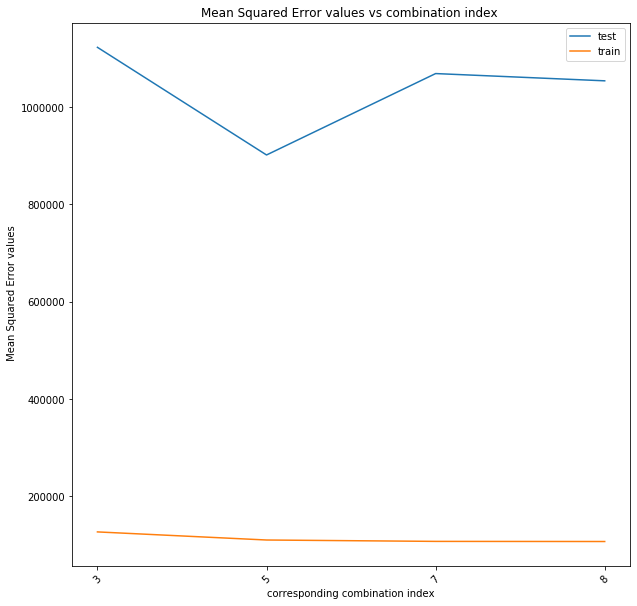

In [16]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(list(score.values()))) , list(score.values())   ,label="test");

plt.plot(np.arange(len(list(score_train.values()))) , list(score_train.values())  ,label="train" );

plt.xticks(np.arange(len(list(score.values()))), [3,5,7,8],rotation=45);
plt.xlabel("corresponding combination index");
plt.ylabel(" Mean Squared Error values");
plt.title("Mean Squared Error values vs combination index ");

plt.legend();

## The best value or the least error on test set is with step_size=0.5 and max_depth=3

In [ ]:
            gt = GBTRegressor(featuresCol ='features', labelCol = 'Weighted_Price',stepSize=0.5,maxIter=20,maxDepth=3)
            gt_model = gt.fit(train_data)
            end = time()-now
            gt_predictions = gt_model.transform(test_data)
            gt_predictions_train = gt_model.transform(train_data)
            gt_evaluator = RegressionEvaluator(
                labelCol="Weighted_Price", predictionCol="prediction", metricName="mse")
            mae = RegressionEvaluator(predictionCol="prediction", \
                         labelCol='Weighted_Price',metricName="mae")
            mse = gt_evaluator.evaluate(gt_predictions)
            mse_train = gt_evaluator.evaluate(gt_predictions_train)
            gt_predictions.select("features",'Weighted_Price','prediction').show(5)
            gt_predictions_train.select("features",'Weighted_Price','prediction').show(5)
            print("Mean Squared Error (MSE) on test data = %g" % mse)
            print("Mean Squared Error (MSE) on train data = %g" % mse_train)
            print("Mean Absolute Error on test data = %g" % mae.evaluate(gt_predictions))
            print("Mean Absolute Error on train data = %g" % mae.evaluate(gt_predictions_train))
            

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_data.select('Weighted_Price').toPandas());
plt.plot(gt_predictions.select('prediction').toPandas());
plt.title("Predicted Price vs. Truth");
plt.ylabel("Weighted Price USD");
plt.legend(["True", "Gradient Boosted regression Predictions"]);